# This notebook generates simulated data and figures to highlight the concepts discussed in the aperiodic recommendations paper


### Issue

<>

### Solution

<>

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [7]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


from neurodsp.sim import sim_combined, sim_synaptic_current, sim_synaptic_kernel, sim_knee, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times

import fooof

In [8]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [121]:
import seaborn as sns
sns.set_context('talk')

In [122]:
# Set random seed
random.seed(420)

In [11]:
# Set whether to save out figures
SAVE_FIG = False

## Figure x in paper (Belonging to Recommendation 1)

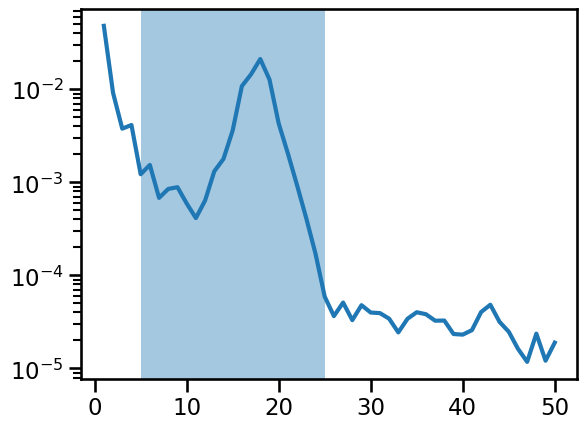

In [123]:
## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-2, 'knee':0}}
fs = 1000
n_seconds = 10
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
sig = sim_peak_oscillation(ap_sig, fs, freq=18, bw=3.5, height=2.5)

## Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(sig, fs=fs, f_range=(1,50), avg_type='median', nperseg=fs, noverlap=fs/2)

plt.semilogy(freqs,powers, linewidth=3)
plt.axvspan(5,25, alpha=0.4)

Text(0, 0.5, 'log(Power)')

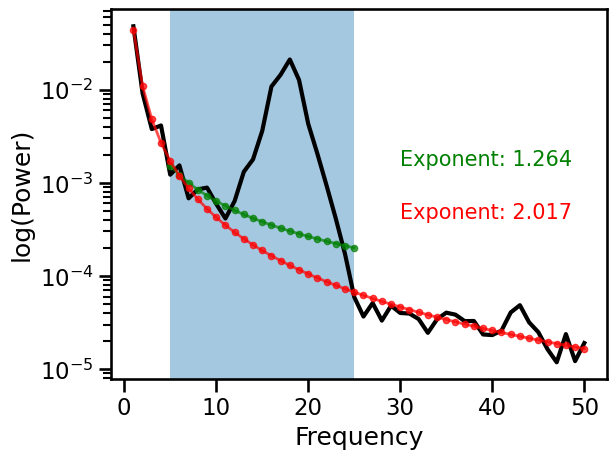

In [125]:
init_settings = {'peak_width_limits':(2,12), 'peak_threshold':2.5}

fit_settings = {'freq_range':(1,50)}
fm_wide = fooof.FOOOF(**init_settings)
fm_wide.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
wide_exp = np.round(fm_wide.get_results().aperiodic_params[1], decimals=3)
fm_wide_ap_fit = fm_wide.get_model(component='aperiodic', space='linear')
fm_wide_freqs = fm_wide.freqs

fit_settings = {'freq_range':(5,25)}
fm_beta = fooof.FOOOF(**init_settings)
fm_beta.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
beta_exp = np.round(fm_beta.get_results().aperiodic_params[1], decimals=3)
fm_beta_ap_fit = fm_beta.get_model(component='aperiodic', space='linear')
fm_beta_freqs = fm_beta.freqs

plt.semilogy(freqs,powers, linewidth=3, color='k')
plt.semilogy(fm_beta_freqs,fm_beta_ap_fit, linewidth=2, marker='.', alpha=0.7, color='green')
plt.semilogy(fm_wide_freqs,fm_wide_ap_fit, linewidth=2, marker='.', alpha=0.7, color='red')
plt.text(x=30,y=powers[5], s=f'Exponent: {beta_exp}', color='green', fontsize=15)
plt.text(x=30,y=powers[10], s=f'Exponent: {wide_exp}', color='red', fontsize=15)
plt.axvspan(5,25, alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('log(Power)')


## Figure x in paper (Belonging to Recommendation 2)

### Simulate neural time series

In [14]:
sim_components = {'sim_powerlaw': {'exponent' : -2},
                   'sim_oscillation': [{'freq' : 8}, {'freq' : 20}]}
sig = sim_combined(n_seconds=1, fs=500, components=sim_components)

times = create_times(n_seconds=1, fs=500)

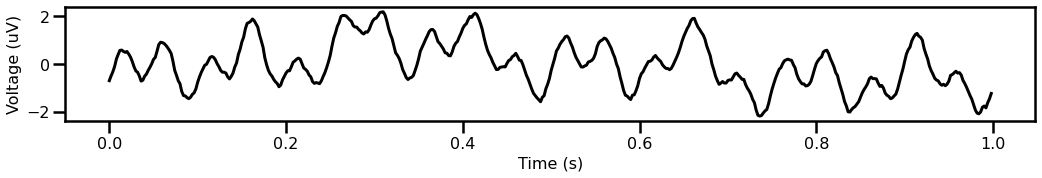

In [15]:
plot_time_series(times, sig)

### Zero-pad and mirror-pad time-signal

In [26]:
zero_pad = np.zeros(100) # Add 100 datapoints => 200 ms
mirror_pad_beg = np.flip(sig[:100])
mirror_pad_end = np.flip(sig[-100:])

In [27]:
sig_zero = np.concatenate((zero_pad, sig, zero_pad))
sig_mirror = np.concatenate((mirror_pad_beg, sig, mirror_pad_end))

times_pad = create_times(n_seconds=1.4, fs=500)

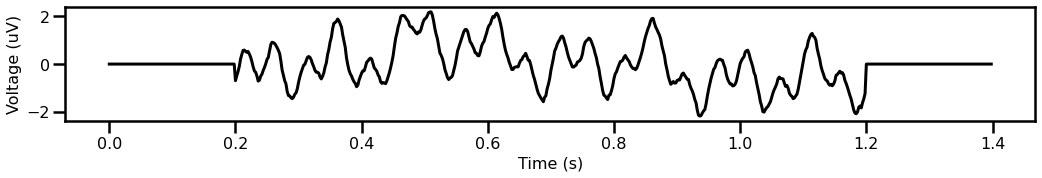

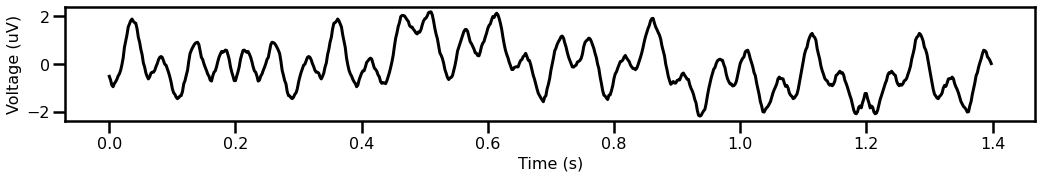

In [29]:
plot_time_series(times_pad, sig_zero)
plot_time_series(times_pad, sig_mirror)

In [43]:
# For plotting purposes: add nans to original signal so it's alligned with the padded ones
nan_pad = np.full(100, np.nan) # Add 100 datapoints => 200 ms
sig_ori = np.concatenate((nan_pad, sig, nan_pad))


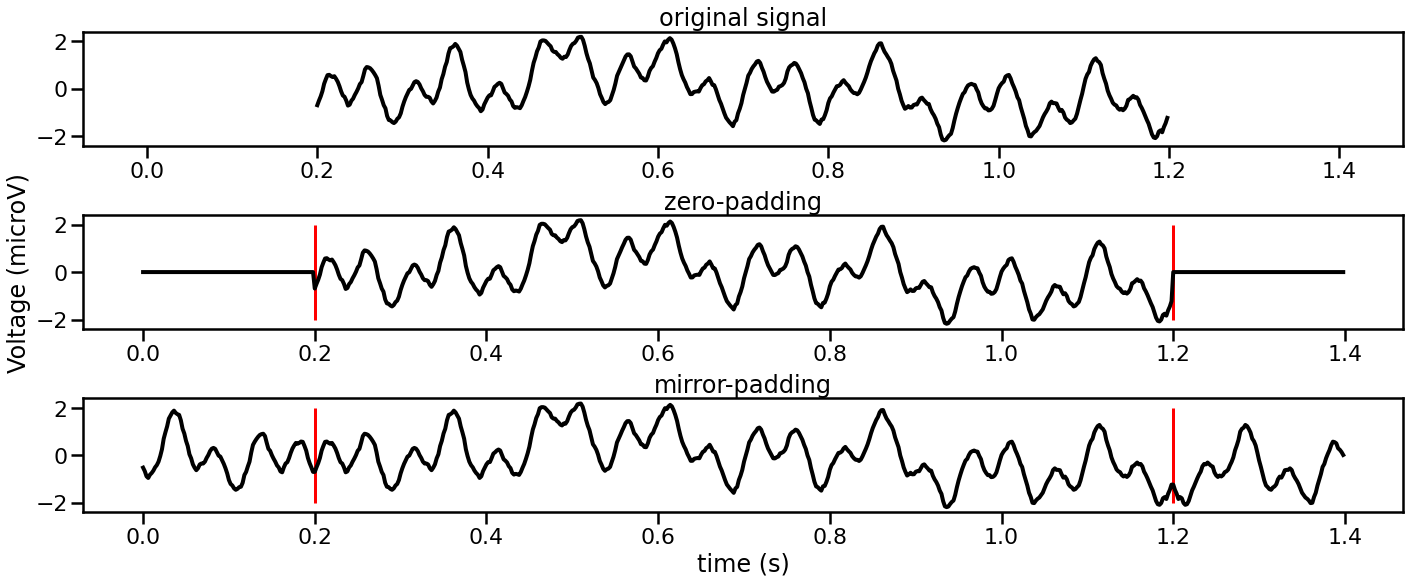

In [79]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[20,8])
fig.tight_layout()

axs[0].plot(times_pad, sig_ori, lw=4, color='black')
axs[1].plot(times_pad, sig_zero, lw=4, color='black')
axs[2].plot(times_pad, sig_mirror, lw=4, color='black')

# Change x-axis limit for original signal
axs[0].set_xlim([-0.075, 1.475])

# Add vertical line
axs[1].vlines(0.2, -2, 2, color='red')
axs[1].vlines(1.2, -2, 2, color='red')
axs[2].vlines(0.2, -2, 2, color='red')
axs[2].vlines(1.2, -2, 2, color='red')

axs[0].set_title('original signal')
axs[1].set_title('zero-padding')
axs[2].set_title('mirror-padding')

axs[2].set_xlabel('time (s)')
axs[1].set_ylabel('Voltage (microV)')


plt.show()

----------------------------------

## Figure x in paper (Belonging to Recommendation 3)

### Generate PSD with & without Knee

c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\neurodsp\sim\transients.py:67: UserWarning: Rise time constant should be shorter than decay time constant.
  warn('Rise time constant should be shorter than decay time constant.')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


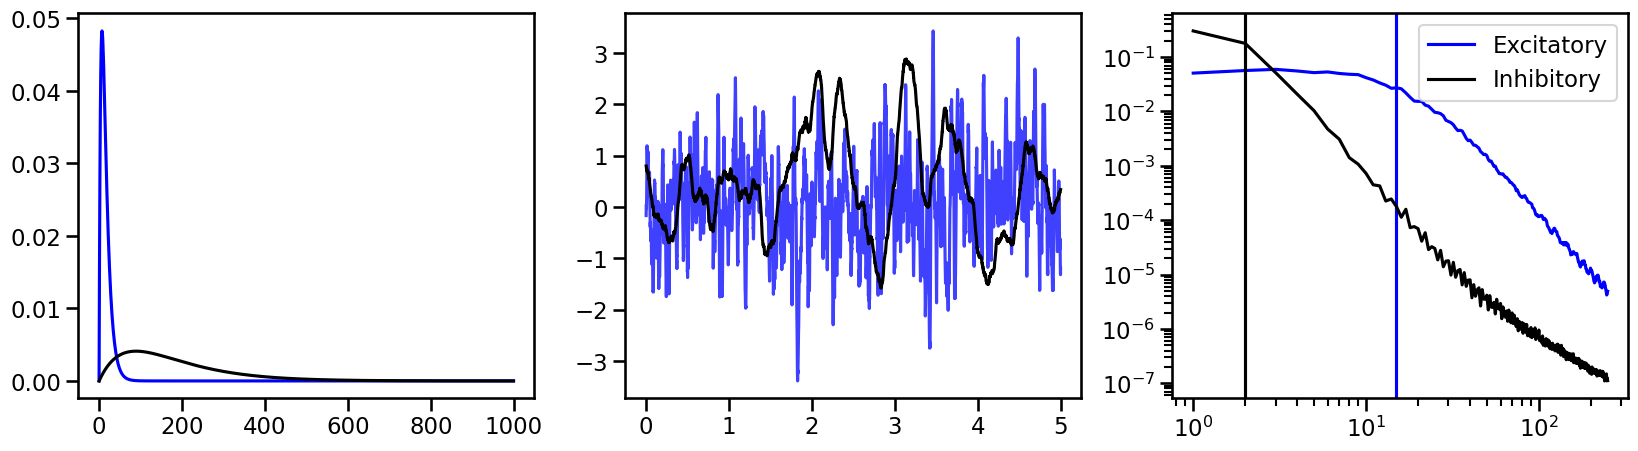

In [166]:
highKnee = 15
lowKnee = 2

tau_E = (0.005, (1/(2*np.pi*highKnee))) #rise, decay
tau_I = (0.1, (1/(2*np.pi*lowKnee))) #rise, decay
n_E = 8000
n_I = 2000
firRate_E = 2 # Hz
firRate_I = 2 # Hz
scale_I = 1
n_seconds = 200
fs=1000
f_range = (1,250)


fig,ax = plt.subplots(1,3, figsize=(20,5))

## Simulate synaptic kernels with slower and faster rise/decay rates
sig_E_ker = sim_synaptic_kernel(n_seconds=1, fs=fs, tau_r=tau_E[0], tau_d=tau_E[1])
sig_I_ker = sim_synaptic_kernel(n_seconds=1, fs=fs, tau_r=tau_I[0], tau_d=tau_I[1])

ax[0].plot(sig_E_ker, label='Excitatory', color='b')
ax[0].plot(sig_I_ker, label='Inhibitory', color='k')
plt.legend()

## Use these to simulate currents from both of these; this will give us a slower (inhibitory) signal, and a faster (excitatory) one
sig_E = sim_synaptic_current(n_seconds=n_seconds, fs=fs, n_neurons=n_E, firing_rate=firRate_E, tau_r=tau_E[0], tau_d=tau_E[1])
sig_I = sim_synaptic_current(n_seconds=n_seconds, fs=fs, n_neurons=n_I, firing_rate=firRate_I, tau_r=tau_I[0], tau_d=tau_I[1])*scale_I
time = np.arange(0,len(sig_E))/fs
# only plotting the first 5 seconds for ease of vis
ax[1].plot(time[time<5],sig_E[time<5], label='E', alpha=0.75, color='b')
ax[1].plot(time[time<5],sig_I[time<5], label='I', color='k')

## Calc PSDs for each timeseries and plot; these should have different knees
freqs_fast, powers_fast = compute_spectrum(sig_E, fs, f_range=f_range, avg_type='mean', nperseg=fs, noverlap=fs/2)
freqs_slow, powers_slow = compute_spectrum(sig_I, fs, f_range=f_range, avg_type='mean', nperseg=fs, noverlap=fs/2)

ax[2].loglog(freqs_fast, powers_fast, label='Excitatory', color='b')
ax[2].axvline(highKnee, color='b')
ax[2].loglog(freqs_slow, powers_slow, label='Inhibitory', color='k')
ax[2].axvline(lowKnee, color='k')

plt.legend()




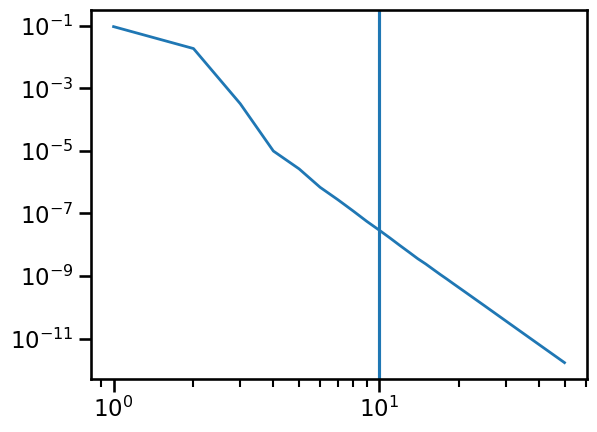

In [202]:
## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {'sim_knee': {'exponent1' : -1, 'exponent2':-10, 'knee':10}}
fs = 2000
n_seconds = 20
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])

## Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(ap_sig, fs=fs, f_range=(1,50), avg_type='median', nperseg=fs, noverlap=fs/2)
plt.loglog(freqs,powers, linewidth=2)
plt.axvline(10)


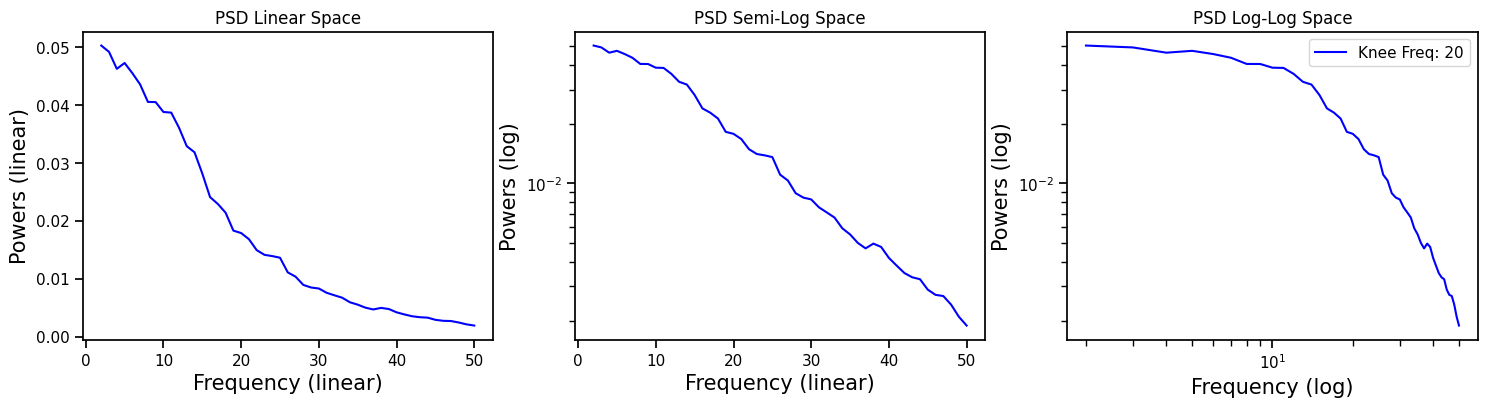

In [235]:
sns.set_context('notebook')
highKnee = 20
tau_E = (0.005, (1/(2*np.pi*highKnee))) #rise, decay
n_E = 8000
firRate_E = 2 # Hz
n_seconds = 200
fs=1000
f_range = (2,50)


fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(18,4))
labels_size=15

## Use these to simulate currents from both of these; this will give us a slower (inhibitory) signal, and a faster (excitatory) one
sig_E = sim_synaptic_current(n_seconds=n_seconds, fs=fs, n_neurons=n_E, firing_rate=firRate_E, tau_r=tau_E[0], tau_d=tau_E[1])

## Calc PSDs for each timeseries and plot; these should have different knees
freqs_fast, powers_fast = compute_spectrum(sig_E, fs, f_range=f_range, avg_type='mean', nperseg=fs, noverlap=fs/2)

ax[0].set_title('PSD Linear Space')
ax[0].plot(freqs_fast, powers_fast, label=f'Knee Freq: {highKnee}', color='b')
ax[0].set_xlabel('Frequency (linear)', fontsize=labels_size)
ax[0].set_ylabel('Powers (linear)', fontsize=labels_size)
#ax[0].axvline(highKnee, color='b')
#plt.legend()
#plt.show()

ax[1].set_title('PSD Semi-Log Space')
ax[1].semilogy(freqs_fast, powers_fast, label=f'Knee Freq: {highKnee}', color='b')
ax[1].set_xlabel('Frequency (linear)', fontsize=labels_size)
ax[1].set_ylabel('Powers (log)', fontsize=labels_size)
#ax[1].axvline(highKnee, color='b')

ax[2].set_title('PSD Log-Log Space')
ax[2].loglog(freqs_fast, powers_fast, label=f'Knee Freq: {highKnee}', color='b')
ax[2].set_xlabel('Frequency (log)', fontsize=labels_size)
ax[2].set_ylabel('Powers (log)', fontsize=labels_size)
#ax[2].axvline(highKnee, color='b')
plt.legend()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.7758, 1.0360                                          
                                                                                                  
                                       2 peaks were found:                                        
          

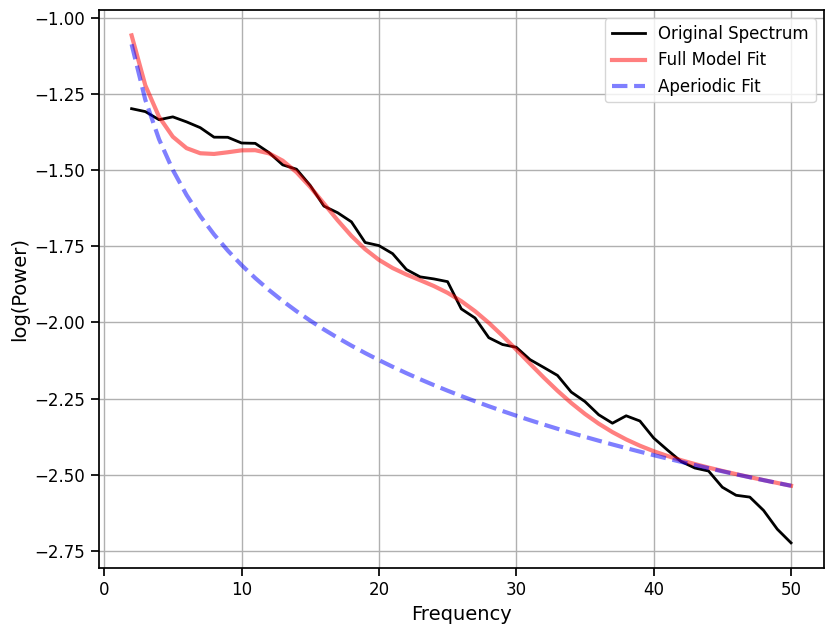

In [236]:
fit_settings = {'freq_range':(2,50)}
init_settings = {'peak_width_limits':(2,12), 'peak_threshold':2, 'aperiodic_mode':'fixed'}

fm = fooof.FOOOF(**init_settings)
fm.fit(freqs=freqs_fast, power_spectrum=powers_fast, **fit_settings)
#exp = np.round(fm.get_results().aperiodic_params[1], decimals=3)
#frange = ax_dict[i]['freq_range']
fm.report()#plot(ax=ax[i])

### Conclusion

<>